# Coincidence detection and sound localisation

This notebook shows some Python + Brian code to simulate spiking neural networks solving a sound localisation task using coincidence detection.

[Brian](https://briansimulator.org) is a Python-based spiking neural network simulator package. It is simple to install and has extensive documentation. I recommend it for this course and more generally. It is entirely coincidental that I'm one of the authors.

## The model

In this notebook, which leads in to the exercise for the first half of the tutorial, we'll construct a highly simplified model of sound localisation carried out by coincidence detection and delay lines. This model was proposed by [Jeffress (1948)]() and is explained in more detail [here](http://www.scholarpedia.org/article/Jeffress_model).

The basic idea is that you have an incoming auditory signal arriving from some angle $\theta$, so it arrives at one ear earlier than the other:

![ITD](itd.png)

We call the difference in arrival time the *interaural time difference* or ITD. In this notebook, the signal will be a sine wave at frequency $f$ and so this time difference is ambiguous and becomes an *interaural phase difference* (IPD). The two are related by $\mathrm{IPD}=2\pi f\cdot\mathrm{ITD}$.

In Jeffress' model the brain tries to infer the ITD by compensating with multiple neural delay lines:

![Jeffress](jeffress.png)

Each circle is a coincidence detector neuron, and the signal travels along the lines at a fixed speed. So, the signal from the left ear reaches the leftmost coincidence detector neuron first, and the rightmost neuron last. The signal from the right ear is the opposite, it reaches the rightmost neuron first and the leftmost neuron last. For each neuron there is a *best ITD* where the neural delays exactly compensate the acoustic delays (ITD). Since coincidence detector neurons fire more frequently if they are receiving inputs that are more similar, you can estimate the ITD of the sound by which neuron is firing at the highest rate (you estimate that the ITD of the sound is the best ITD of that neuron).

## Coding it up

In the rest of this notebook, we'll turn this idea into code.

First of all, we import the plotting libraries and the Brian simulator package. Note that I'm doing some funky stuff here to make it work locally and also in Google Colab, etc.

You can ignore the ``prefs.codegen...`` line for the moment. It makes it run faster for small models but slower for fast models, so it's handy for demos.

In [1]:
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None
    
try:
    import brian2
except ImportError:
    !pip install brian2
    
%matplotlib inline
from brian2 import *
import matplotlib.gridspec as gridspec

prefs.codegen.target = 'numpy'

### Input signal

Now we set up the input signal model. We'll have the two ears receive two sine waves with different phase delays, ear 0 will have no delay, and ear 1 will have a delay of ``ipd``. Then, we'll have the neurons generate spikes as a Poisson process with firing rate ``rate_max*0.5*(1+sin(theta))``. We model this in Brian by having a spike threshold condition ``rand()<rate*dt`` where ``rand()`` is a uniform random number in ``[0, 1]`` and ``dt`` is the simulation time step. We can take a look at what this model looks like by running the cell below.

In [2]:
def input_signal(rate_max_Hz=100, ipd_deg=90, f_Hz=3):
    # We can't use values with units in the widgets, so we add the units first
    rate_max = rate_max_Hz*Hz
    ipd = (pi/180)*ipd_deg
    f = f_Hz*Hz
    
    # These are the equations governing the ear neurons. Take a look at the
    # Brian documentation for an explanation, but the only thing you might
    # find non-obvious hopefully is the ": 1" and ": Hz" which tells Brian
    # what the units of the variable being defined are (1 means dimensionless).
    # Also note that the variable "i" is defined in Brian to be the index of
    # the neuron, so for neuron 0 it will be 0 and for neuron 1 it will be 1,
    # allowing us to make the input signal different for the two ears.
    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    rate = rate_max*0.5*(1+sin(theta)) : Hz
    '''
    
    # Create a group of 2 neurons with these equations, that fires a spike
    # according to a Poisson process with the given time-varying rate. We
    # use a dt of 1ms to speed up the simulation for interactivity, but later
    # we'll use a better default of 0.1ms.
    ears = NeuronGroup(2, eqs_ears, threshold='rand()<rate*dt', dt=1*ms)
    
    # Record the spikes and values of the rate as we run the simulation
    M_spike = SpikeMonitor(ears)
    M_state = StateMonitor(ears, 'rate', record=True)
    
    # Run the simulation for 1 second
    run(1*second)

    # Now plot the results. I won't explain in detail because it's mostly
    # just fiddly matplotlib stuff to make it look nice.
    trains = M_spike.spike_trains()
    fig = figure(figsize=(4, 2), dpi=200)
    gs = gridspec.GridSpec(2, 1, hspace=0, height_ratios=[1, .3])
    ax = subplot(gs[0])
    plot(M_state.t/ms, M_state.rate[0]/Hz, label='Left ear')
    plot(M_state.t/ms, M_state.rate[1]/Hz, label='Right ear')
    legend(loc='upper right')
    gca().set_frame_on(False)
    ylabel('Rate')
    yticks([])
    xticks([])
    ylim(-10, 210)
    subplot(gs[1], sharex=ax)
    plot(trains[0]/ms, [0]*len(trains[0]), '|')
    plot(trains[1]/ms, [1]*len(trains[1]), '|')
    ylim(-1, 2)
    gca().set_frame_on(False)
    xlabel('Time')
    ylabel('Spikes')
    yticks([])
    xticks([])
    tight_layout()

if widgets is not None:
    widgets.interact(input_signal,
        rate_max_Hz=widgets.IntSlider(min=10, max=200, value=100, step=10, continuous_update=False),
        ipd_deg=widgets.IntSlider(min=0, max=360, value=90, step=10, continuous_update=False),
        f_Hz=widgets.FloatSlider(min=0, max=10, value=3, step=.1, continuous_update=False),
        );
else:
    input_signal()

interactive(children=(IntSlider(value=100, continuous_update=False, description='rate_max_Hz', max=200, min=10…

### Coincidence detectors

Now we're going to set up the coincidence detector neurons. We'll use $N$ neurons with best delays equally distributed between 0 and $\mathrm{ITD}_\mathrm{max}=1/f$. The coincidence detector neurons are standard LIF neurons like we've seen before, but we store a copy of their best IPD and best ITD. Next, we create synapses from the ear neurons to the coincidence detector neurons where the synaptic delay from ear 0 is 0, and from ear 1 is the best ITD of that neuron. We use a small time constant $\tau$ to get strong coincidence detection, and plot the results.

In [3]:
def localise(rate_max_Hz=400, ipd_deg=200, f_Hz=50, w=0.5, tau_ms=1, N_cd=100, duration=1*second):
    rate_max = rate_max_Hz*Hz
    ipd = (pi/180)*ipd_deg
    f = f_Hz*Hz
    tau = tau_ms*ms
    itd = ipd/(2*pi*f)

    # One difference from before is that we handle edge effects here, by making sure the signal
    # is the same on both sides by padding with rate=0.5*rate_max at the beginning/end. The
    # code for this is a bit clever/tricky and not essential to understand immediately.
    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max*0.5*(1+signal_is_on*sin(theta)) : Hz
    '''

    ears = NeuronGroup(2, eqs_ears, threshold='rand()<rate*dt')
    
    # Standard LIF neuron but with added best IPD and best ITD that depends on the neuron
    # index (equally distributed in the possible range).
    eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''
    cd = NeuronGroup(N_cd, eqs_cd, threshold='v>1', reset='v=0', method='exact')
    
    # Synapses from the ears to the coincidence detector neurons. If a presynaptic neuron
    # fires, the postsynaptic v value is increased by w.
    S = Synapses(ears, cd, on_pre='v += w')
    # All presynaptic neurons connected to all postsynaptic neurons
    S.connect(p=1)
    # Delays are 0 by default, so we set the delays for where the presynaptic neuron has
    # index 1 (the right ear) to be the best_itd of the post-synaptic neuron.
    S.delay['i==1'] = 'best_itd'
    
    M = SpikeMonitor(cd)
    
    run(duration)
    
    # We take as our estimate the mean best IPD of all neurons with
    # the maximum spike count
    i = max(M.count)
    I = M.count==i
    ipd_est = mean(cd.best_ipd[I])
    
    figure(figsize=(6, 4), dpi=100)
    plot(cd.best_ipd[I]*180/pi, M.count[I], 'or')
    plot(cd.best_ipd*(180/pi), M.count, '.k')
    axvline(ipd_deg, ls='--', c='b', label='True IPD')
    axvline(ipd_est*180/pi, ls='--', c='r', label='Estimated IPD')
    xlabel('IPD (deg)')
    ylabel('Spike count')
    legend(loc='lower right')
    tight_layout()
    

if widgets is not None:
    widgets.interact(localise,
        rate_max_Hz=widgets.IntSlider(min=10, max=1000, value=400, step=10, continuous_update=False),
        ipd_deg=widgets.IntSlider(min=0, max=360, value=90, step=10, continuous_update=False),
        f_Hz=widgets.IntSlider(min=0, max=200, value=50, step=5, continuous_update=False),
        w=widgets.FloatSlider(min=.1, max=1, value=.5, step=.1, continuous_update=False),
        tau_ms=widgets.FloatSlider(min=.1, max=10, value=1, step=.1, continuous_update=False),
        N_cd=widgets.IntSlider(min=10, max=1000, value=100, step=10, continuous_update=False),
        duration=widgets.fixed(1*second),
        );
else:
    localise()

interactive(children=(IntSlider(value=400, continuous_update=False, description='rate_max_Hz', max=1000, min=1…

### Evaluating performance

How well does this model perform? Let's try it out. We'll run it once for each IPD from 0 to 360 degrees in steps of 10 degrees, and plot the estimated IPDs and errors as a function of IPD, and compute the mean error.

We'll separate out the functions a bit. The first function computes the input signal and returns the spike times. The second function estimates the IPD from it. This is partly for the exercise (below) but also just to make sure we're not accidentally using information about the true answer when computing our estimate.

In [4]:
!pip install tqdm
from tqdm.auto import tqdm

In [5]:
rate_max = 400*Hz
f = 50*Hz
duration = 1*second
w = 0.5
tau = 1*ms
N_cd = 100

# This one generates an input signal and returns a pair (i, t) of
# arrays with i the spike indices (0 or 1 as there are 2 neurons)
# and t the corresponding spike times.
def generate_input_signal(ipd):
    itd = ipd/(2*pi*f)

    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max*0.5*(1+signal_is_on*sin(theta)) : Hz
    '''

    ears = NeuronGroup(2, eqs_ears, threshold='rand()<rate*dt')
    
    M = SpikeMonitor(ears)

    run(duration)
    
    return M.i, M.t


# This one performs the localisation from before, using just those
# arrays returned by the previous function, which we convert into
# a group of neurons in Brian using SpikeGeneratorGroup
def localise_from_input(i, t):
    ears = SpikeGeneratorGroup(2, i, t)
    
    eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''
    cd = NeuronGroup(N_cd, eqs_cd, threshold='v>1', reset='v=0', method='exact')
    
    S = Synapses(ears, cd, on_pre='v += w')
    S.connect(p=1)
    S.delay['i==1'] = 'best_itd'
    
    M = SpikeMonitor(cd)
    
    run(duration)
    
    i = max(M.count)
    I = M.count==i
    ipd_est = mean(cd.best_ipd[I])
    
    return ipd_est


def generate_and_localise(ipd, localiser):
    i, t = generate_input_signal(ipd)
    return localiser(i, t)

def generate_results(localiser, step_deg=10):
    ipds = arange(0, 360, step_deg)*pi/180
    ipds_est = array([generate_and_localise(ipd, localiser) for ipd in tqdm(ipds)])
    return ipds, ipds_est

In [6]:
# This will take a minute or so to run.
ipds, ipds_est = generate_results(localise_from_input)

  0%|          | 0/36 [00:00<?, ?it/s]

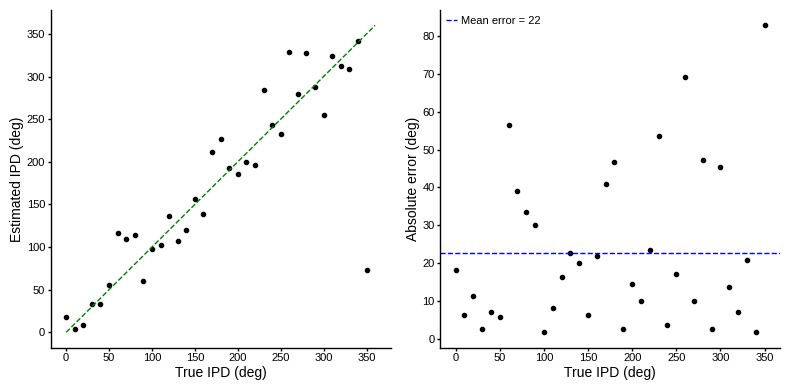

In [7]:
# Mean error should be calculated in a circular fashion
# Giving 359 degrees when the answer is 0 is 1 degree not 359
# So compute +-360 deg and take the minimum
def compute_errors(ipds, ipds_est):
    ipds_est_circ = array([ipds_est, ipds_est+2*pi, ipds_est-2*pi])
    abs_errors_circ = abs(ipds[newaxis, :]-ipds_est_circ)
    abs_errors_deg = amin(abs_errors_circ, axis=0)*180/pi
    return abs_errors_deg


def plot_results(ipds, ipds_est):
    abs_errors_deg = compute_errors(ipds, ipds_est)
    figure(figsize=(8, 4), dpi=100)
    subplot(121)
    plot(ipds*180/pi, ipds_est*180/pi, '.k')
    plot([0, 360], [0, 360], '--g')
    xlabel('True IPD (deg)')
    ylabel('Estimated IPD (deg)')
    subplot(122)
    plot(ipds*180/pi, abs_errors_deg, '.k')
    mean_abs_error_deg = mean(abs_errors_deg)
    axhline(mean_abs_error_deg, ls='--', c='b', label=f'Mean error = {int(mean_abs_error_deg)}')
    xlabel('True IPD (deg)')
    ylabel('Absolute error (deg)')
    legend(loc='best')
    tight_layout();
    
plot_results(ipds, ipds_est)

## Exercise

Can you do better than the network above? Limit yourself to only 100 neurons, and use the ``generate_input_signal`` function from above to generate the input data, but otherwise feel free to do whatever you like. Some ideas:

* Optimise the parameters ``tau``, ``w``
* Use a different neuron model
* Use a different method to estimate the IPD given the set of coincidence detector neuron counts

After you've had a go, you might be interested in our related paper [Goodman et al. (2013)](https://elifesciences.org/articles/01312).

### My attempt

In [8]:
def build_localiser(tau):
    rate_max = 400*Hz
    f = 50*Hz
    duration = 1*second
    w = 0.5
    N_cd = 100
    # taus = np.ones(N_cd) * ms


    # This one performs the localisation from before, using just those
    # arrays returned by the previous function, which we convert into
    # a group of neurons in Brian using SpikeGeneratorGroup
    def localise_from_input_tau(i, t):
        ears = SpikeGeneratorGroup(2, i, t)

        eqs_cd = '''
        tau : second
        dv/dt = -v/tau : 1
        best_ipd = 2*pi*i/(N_cd-1) : 1
        best_itd = best_ipd/(2*pi*f) : second
        '''
        cd = NeuronGroup(N_cd, eqs_cd, threshold='v>1', reset='v=0', method='exact')
        cd.tau = tau*ms

        S = Synapses(ears, cd, on_pre='v += w')
        S.connect(p=1)
        S.delay['i==1'] = 'best_itd'

        M = SpikeMonitor(cd)

        run(duration)

        i = max(M.count)
        I = M.count==i
        ipd_est = mean(cd.best_ipd[I])

        return ipd_est

    return localise_from_input_tau


test_taus = np.linspace(1, 3, 11)
mean_errs = []

for tau in tqdm(test_taus):
    ipds, ipds_est = generate_results(build_localiser(tau), step_deg=10)
    mean_errs.append(np.mean(compute_errors(ipds, ipds_est)))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.6. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2.2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2.4000000000000004. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2.6. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2.8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


  0%|          | 0/36 [00:00<?, ?it/s]

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 3.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


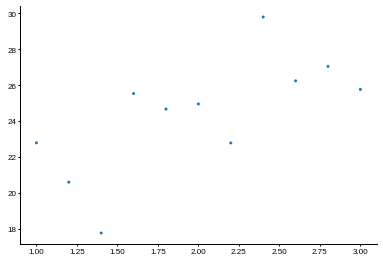

In [9]:
_, ax = plt.subplots()
ax.scatter(test_taus, mean_errs)

In [10]:
test_taus

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])